In [ ]:
import pandas as pd
import re
import torch, torchaudio
import torch.nn as nn
import random
from tqdm import tqdm
import csv
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
import pytesseract
from datasets import load_dataset
import os
import io
import clip
import librosa
from datasets import load_dataset
import numpy as np
from audio_feature_projector import AudioFeatureProjector
from audio_model import audio_preprocess
from image_model import image_preprocess
from audio_dataset import AudioDataset
from image_dataset import ImageTextDataset
from multi_modal_model import MultimodalModel
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support


In [ ]:
raw_path = '/teamspace/studios/this_studio/NLP_data/Image_data/kaggle_image_data/labels.csv'
image_dir = '/teamspace/studios/this_studio/NLP_data/Image_data/kaggle_image_data/images'
audio_data = pd.read_csv('/teamspace/studios/this_studio/NLP_data/audio_data/kaggle_audio_data/TEST.CSV')
audio_dir = '/teamspace/studios/this_studio/NLP_data/audio_data/kaggle_audio_data/TEST'
data = pd.read_csv(raw_path)
raw_data = pd.read_csv(raw_path)
raw_data['image_name']
raw_data['image_path'] = raw_data['image_name'].apply(lambda x: os.path.join(image_dir, x))


In [ ]:
split_index = int(len(raw_data) * 0.8)

image_train = raw_data.iloc[:split_index]
image_test = raw_data.iloc[split_index:]

In [ ]:

audio_data['audio_path'] = audio_data['Filename'].apply(lambda x: os.path.join(audio_dir, x))
audio_data = audio_data.drop(columns=['Filename'])
# Convert labels to integers
label_mapping = {'positive': 1, 'negative': 0, 'neutral': 2}  # Define your mapping here
audio_data['label'] = audio_data['label'].map(label_mapping)


In [ ]:
ds_train = load_dataset("DynamicSuperb/Sentiment_Analysis_SLUE-VoxCeleb")
ds_test = load_dataset("DynamicSuperb/SentimentAnalysis_SLUE-VoxCeleb")

In [ ]:
ds_train = ds_train['test'].select_columns(['audio', 'label'])
ds_test = ds_test['test'].select_columns(['audio', 'label'])

In [ ]:
def array_append(ds):
    audio_array = []
    sampling_rate = []
    labels = []
    for x in ds:
        audio_array.append(x['audio']['array'])
        sampling_rate.append(x['audio']['sampling_rate'])
        labels.append(x['label'])
    
    audio_data = {
    'array': audio_array,
    'sampling_rate': sampling_rate,
    'label': labels
    }

    return pd.DataFrame.from_dict(audio_data)

In [ ]:
label_mapping = {'Positive': 1, 'Negative': 0, 'Neutral': 2}  # Define your mapping here
audio_df_train['label'] = audio_df_train['label'].map(label_mapping)
audio_df_test['label'] = audio_df_test['label'].map(label_mapping)
audio_df_train.head, audio_df_test.head

In [ ]:
audio_df_train = audio_df_train.dropna(axis = 0)
audio_df_test = audio_df_test.dropna(axis = 0)
audio_df_train['label'] = audio_df_train['label'].astype(int)

In [ ]:
audio_dataset = AudioDataset(dataframe=audio_df_train, audio_array='array', sampling_rate='sampling_rate',target_column='label', feature_extractor = audio_preprocess)
dataloader = DataLoader(audio_dataset, batch_size= 32, shuffle=True)

In [ ]:
image_dataset = ImageTextDataset(image_train, image_column="image_path", text_column="text_ocr", image_preprocess=image_preprocess)
image_dataloader = DataLoader(image_dataset, batch_size=32, shuffle=True)

# Training the model

In [25]:
batch_size = 32
learning_rate = 0.0001
num_epochs = 25
device = 'cuda' if torch.cuda.is_available() else 'cpu'

multi_model = MultimodalModel(num_classes = 3, device=device)
multi_model.load_state_dict(torch.load("multimodal_model.pth", map_location = torch.device('cpu')))
multi_model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(multi_model.parameters(), lr = learning_rate)

Model training


Epoch 1/25: 100%|██████████| 100/100 [00:00<00:00, 546.12batch/s]


Epoch 1 completed. Training Loss: 1.8200, Validation Loss: 2.3374


Epoch 2/25: 100%|██████████| 100/100 [00:00<00:00, 482.22batch/s]


Epoch 2 completed. Training Loss: 1.6457, Validation Loss: 2.1822


Epoch 3/25:  39%|███▉      | 39/100 [00:00<00:00, 383.91batch/s]

Epoch 3/25: 100%|██████████| 100/100 [00:00<00:00, 380.25batch/s]


Epoch 3 completed. Training Loss: 1.4911, Validation Loss: 2.0565


Epoch 4/25: 100%|██████████| 100/100 [00:00<00:00, 322.55batch/s]


Epoch 4 completed. Training Loss: 1.3541, Validation Loss: 1.9102


Epoch 5/25: 100%|██████████| 100/100 [00:00<00:00, 644.69batch/s]


Epoch 5 completed. Training Loss: 1.1884, Validation Loss: 1.7927


Epoch 6/25: 100%|██████████| 100/100 [00:00<00:00, 838.54batch/s]


Epoch 6 completed. Training Loss: 1.0556, Validation Loss: 1.6655


Epoch 7/25: 100%|██████████| 100/100 [00:00<00:00, 667.52batch/s]


Epoch 7 completed. Training Loss: 0.9300, Validation Loss: 1.5740


Epoch 8/25: 100%|██████████| 100/100 [00:00<00:00, 456.89batch/s]


Epoch 8 completed. Training Loss: 0.7916, Validation Loss: 1.4745


Epoch 9/25: 100%|██████████| 100/100 [00:00<00:00, 658.39batch/s]


Epoch 9 completed. Training Loss: 0.6764, Validation Loss: 1.3822


Epoch 10/25: 100%|██████████| 100/100 [00:00<00:00, 857.17batch/s]


Epoch 10 completed. Training Loss: 0.5991, Validation Loss: 1.2691


Epoch 11/25: 100%|██████████| 100/100 [00:00<00:00, 525.12batch/s]


Epoch 11 completed. Training Loss: 0.5066, Validation Loss: 1.1503


Epoch 12/25: 100%|██████████| 100/100 [00:00<00:00, 511.11batch/s]


Epoch 12 completed. Training Loss: 0.5019, Validation Loss: 1.0829


Epoch 13/25: 100%|██████████| 100/100 [00:00<00:00, 455.73batch/s]


Epoch 13 completed. Training Loss: 0.4088, Validation Loss: 1.0324


Epoch 14/25: 100%|██████████| 100/100 [00:00<00:00, 578.93batch/s]


Epoch 14 completed. Training Loss: 0.3542, Validation Loss: 0.9335


Epoch 15/25: 100%|██████████| 100/100 [00:00<00:00, 368.44batch/s]


Epoch 15 completed. Training Loss: 0.3520, Validation Loss: 0.8630


Epoch 16/25: 100%|██████████| 100/100 [00:00<00:00, 446.33batch/s]


Epoch 16 completed. Training Loss: 0.3488, Validation Loss: 0.8277


Epoch 17/25: 100%|██████████| 100/100 [00:00<00:00, 415.90batch/s]


Epoch 17 completed. Training Loss: 0.3277, Validation Loss: 0.8088


Epoch 18/25: 100%|██████████| 100/100 [00:00<00:00, 356.74batch/s]


Epoch 18 completed. Training Loss: 0.2764, Validation Loss: 0.8367


Epoch 19/25: 100%|██████████| 100/100 [00:00<00:00, 551.94batch/s]


Epoch 19 completed. Training Loss: 0.2376, Validation Loss: 0.8545


Epoch 20/25: 100%|██████████| 100/100 [00:00<00:00, 711.73batch/s]


Epoch 20 completed. Training Loss: 0.1899, Validation Loss: 0.8362


Epoch 21/25: 100%|██████████| 100/100 [00:00<00:00, 291.44batch/s]


Epoch 21 completed. Training Loss: 0.1869, Validation Loss: 0.8415


Epoch 22/25: 100%|██████████| 100/100 [00:00<00:00, 437.85batch/s]


Epoch 22 completed. Training Loss: 0.1880, Validation Loss: 0.8114


Epoch 23/25: 100%|██████████| 100/100 [00:00<00:00, 342.31batch/s]


Epoch 23 completed. Training Loss: 0.1918, Validation Loss: 0.8170


Epoch 24/25: 100%|██████████| 100/100 [00:00<00:00, 544.36batch/s]


Epoch 24 completed. Training Loss: 0.1625, Validation Loss: 0.7700


Epoch 25/25: 100%|██████████| 100/100 [00:00<00:00, 398.56batch/s]


Epoch 25 completed. Training Loss: 0.1944, Validation Loss: 0.7929
Model training complete!


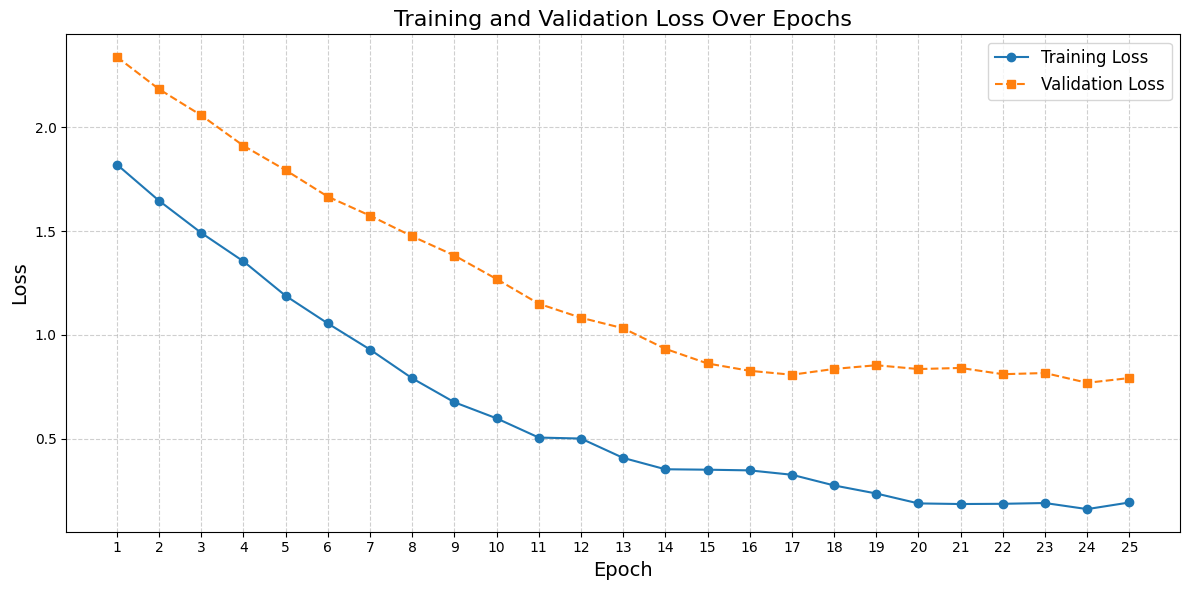

In [10]:
print('Model training')
for epoch in range(num_epochs):
    running_loss = 0.0
    
    with tqdm(dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        
        for features, labels in tepoch:
            # Unpack features and handle missing data (if any features are None)
            (text_features, projected_audio_features, image_features) = features

            # Move data to the appropriate device
            text_features, projected_audio_features, image_features, labels = (
                text_features.to(device).float(),
                projected_audio_features.to(device).float(),
                image_features.to(device).float(),
                labels.to(device),
            )

            # Forward pass
            optimizer.zero_grad()
            outputs = multi_model(text_features, image_features, projected_audio_features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update running loss and progress bar
            running_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())

    with tqdm(image_dataloader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        
        for features, labels in tepoch:
            # Unpack features and handle missing data (if any features are None)
            (text_features, projected_audio_features, image_features) = features

            # Move data to the appropriate device
            text_features, projected_audio_features, image_features, labels = (
                text_features.to(device).float(),
                projected_audio_features.to(device).float(),
                image_features.to(device).float(),
                labels.to(device),
            )

            # Forward pass
            optimizer.zero_grad()
            outputs = multi_model(text_features, image_features, projected_audio_features)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Update running loss and progress bar
            running_loss += loss.item()
            tepoch.set_postfix(loss=loss.item())
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {running_loss/len(dataloader):.4f}")

print("Model training Complete!")


In [ ]:
model_path = "multimodal_model.pth"
torch.save(multi_model.state_dict(), model_path)
print(f"Model weights saved at {model_path}")

# Testing the model

In [ ]:
audio_dataset_test = AudioDataset(dataframe=audio_df_test, audio_array='array', sampling_rate='sampling_rate',target_column='label', feature_extractor = audio_preprocess)
dataloader_test = DataLoader(audio_dataset_test, batch_size= 32, shuffle=True)

image_dataset_test = ImageTextDataset(image_test, image_column="image_path", text_column="text_ocr", image_preprocess=image_preprocess)
image_dataloader_test = DataLoader(image_dataset_test, batch_size=32, shuffle=True)

Accuracy: 88.74%


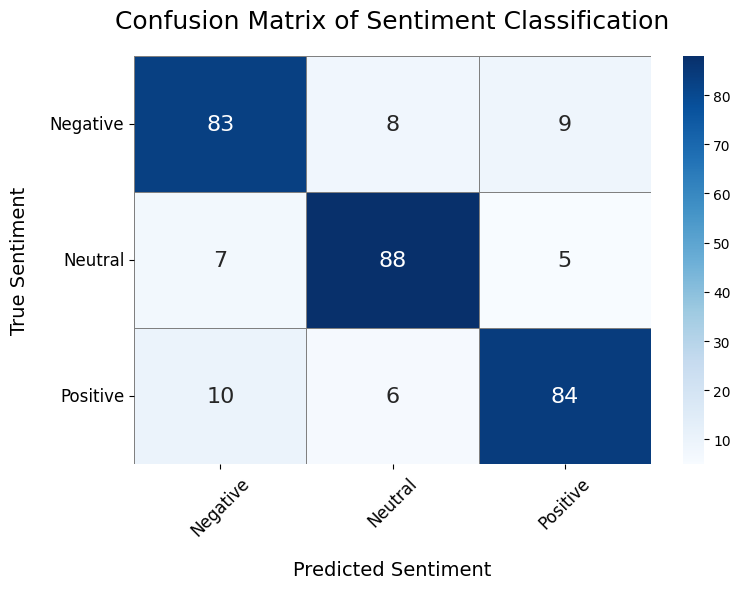

In [2]:
def load_model(model, model_path, device):
    model = model
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model


def evaluate_model(model, test_loader, device, class_names):
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        with tqdm(dataloader, unit="batch") as tepoch:
        
        for features, labels in tepoch:
            # Unpack features and handle missing data (if any features are None)
            (text_features, projected_audio_features, image_features) = features

            # Move data to the appropriate device
            text_features, projected_audio_features, image_features, labels = (
                text_features.to(device).float(),
                projected_audio_features.to(device).float(),
                image_features.to(device).float(),
                labels.to(device),
            )

            # Forward pass
            outputs = multi_model(text_features, image_features, projected_audio_features)
            
            # Collect predictions and labels
            outputs.extend(preds.cpu().numpy())
            labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(labels, outputs)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average=None, labels=range(len(class_names)))
    
    print(f"Accuracy: {accuracy * 100:.2f}%")
    
    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=range(len(class_names)))
    return cm, class_names

def plot_confusion_matrix(cm, class_names, title='Confusion Matrix', cmap='Blues'):
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap=cmap, cbar=True,
                annot_kws={"size": 14}, linewidths=.5, linecolor='gray')
    
    plt.title(title, fontsize=18, pad=20)
    plt.xlabel('Predicted Sentiment', fontsize=14, labelpad=15)
    plt.ylabel('True Sentiment', fontsize=14, labelpad=15)
    
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(rotation=0, fontsize=12)
    plt.tight_layout()
    plt.show()


def main():
    # Define device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
   
    model_path = "multimodal_model.pth"
    
    # Load the model
    model = load_model(multimodal_model, model_path, device)
    
    test_loader = 
    
    class_names = ['Negative', 'Neutral', 'Positive']
    
    # Evaluate the model
    cm, class_names = evaluate_model(model, test_loader, device, class_names)
    
    # Plot the confusion matrix
    plot_confusion_matrix(cm, class_names)

if __name__ == "__main__":
    main()

